In [32]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


warnings.filterwarnings('ignore')

In [2]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve")
    plt.scatter(x=r, y=p, color = 'Green')
    plt.plot(r,p,color= 'Green',linewidth=6.0)
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [3]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [4]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}
dic1 = {'Yes':1,'No':0}
dic2 = {'In State':1,'Out of State':0}
dic3 = {'Owner':1,'1st Gen':0}
dic4 = {'Couple':1,'Single':0}
dic5 = {'Weekday':0, 'Weekend':1}
dic6 = {2017:0, 2018:1}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
df['Homeowner']=df['Homeowner'].replace(dic1)
df['InState']=df['InState'].replace(dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)
df['relationStatus']=df['relationStatus'].replace(dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)
df['Year of TourDate']=df['Year of TourDate'].replace(dic6)

print(len(df['Age']))

15932


In [5]:
#
dfX = df.drop(['ResultOfTour',  'NetVolumePlusNonGoodVolume'], axis = 1)
#
dfX = pd.get_dummies(dfX, prefix=[ 'AgentLine','BookingWindow',
       'HHIncomeRanges', 'Month of TourDate', 'Programs (Budget)','TourSeason'])
#                                 
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])     
#
scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])
#
scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])
#
X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)

dfX1 = X_train
dfY1 = y_train
 
print(len(dfX1['Age']))

12745


In [6]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 1200, num = 3)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 10, 20, 40]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight = {0:0.2,1:0.8})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2,scoring = 'roc_auc', random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(dfX1, dfY1)
print(rf_random.best_params_)
print(rf_random.best_score_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 36.0min finished


{'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
0.6308372663029469


In [8]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10,20,40],
    'min_samples_split': [2,3,4],
    'n_estimators': [1800]
}
# Create a based model
rf = RandomForestClassifier(class_weight = {0:0.3,1:1})
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2, scoring = 'roc_auc')
grid_search.fit(dfX1,dfY1)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.0min finished


0.6308497553306383
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 3, 'n_estimators': 1800}


In [ ]:
print('Actual Close Rate: ',str(round(np.mean(df['ResultOfTour']),3)*100))

In [20]:
rfc =RandomForestClassifier(
    **{'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 4, 'n_estimators': 1400}, 
    class_weight= {0:0.2,1:0.8})
rfc.fit(dfX1,dfY1)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.2, 1: 0.8},
            criterion='gini', max_depth=80, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=1400, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

     pred_neg  pred_pos
neg       837      1777
pos        82       491


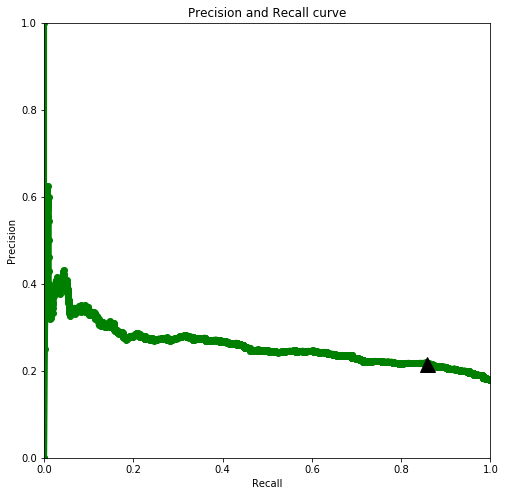

In [26]:
y_scores = rfc.predict_proba(X_test)[:,1]
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.37)

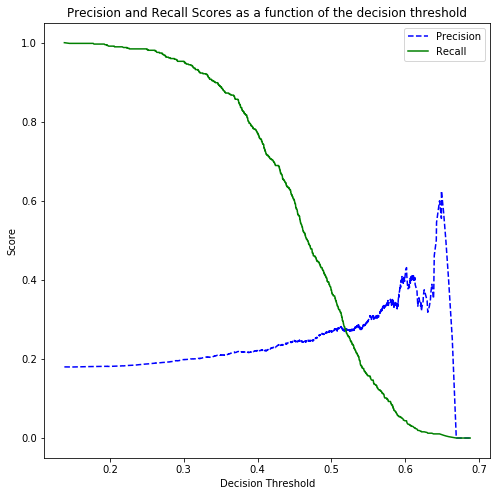

In [27]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
for x,y in sorted(zip(list(rfc.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

In [28]:

Cs = [ 0.01, 0.1, 1, 10,100]

lr = GridSearchCV(estimator = LogisticRegression(class_weight = {0:0.2,1:0.8}), param_grid = dict(C=Cs),scoring = 'roc_auc', cv = 4)
lr.fit(dfX1,dfY1)
print(lr.best_score_)
print(lr.best_params_)


0.6284129986311945
{'C': 100}


     pred_neg  pred_pos
neg       459      2155
pos        39       534


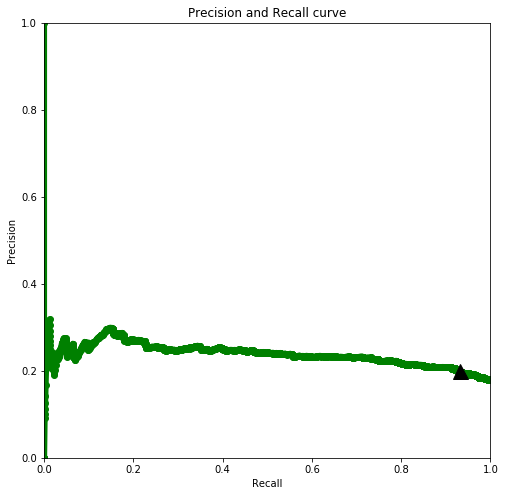

In [52]:
y_scores = lr.predict_proba(X_test)[:,1]
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.5)

In [36]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = [ 'linear', 'poly', 'rbf', 'sigmoid']
params = {'C':Cs,'gamma':gammas, 'kernel':kernels}

svc = GridSearchCV(estimator = SVC(class_weight = {0:0.2,1:0.8}), param_grid = params,scoring = 'roc_auc', n_jobs = -1, verbose = 2, cv = 2)
svc.fit(dfX1,dfY1)
print(svc.best_score_)
print(svc.best_params_)


Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 64.8min finished


0.6368585419239662
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


     pred_neg  pred_pos
neg      2028       586
pos       360       213


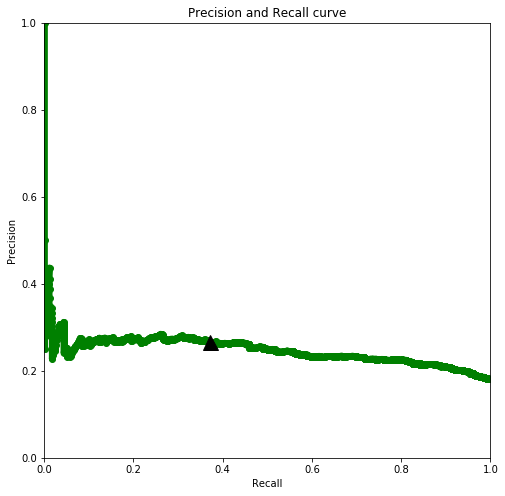

In [45]:
y_scores = svc.decision_function(X_test)
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.3)